In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<br><br>
<font size='6'><b>Deep Learning
</b></font><br><br>

<table style="border-style: hidden; border-collapse: collapse;" width = "80%"> 
    <tr style="border-style: hidden; border-collapse: collapse;">
        <td width = 60% style="border-style: hidden; border-collapse: collapse;">

        </td>
        <td width = 20%>
        By Suhyun Kim<br>iSystems Design Lab<br>http://isystems.unist.ac.kr/<br>UNIST
        </td>
    </tr>
</table>

Table of Contents
<div id="toc"></div>

## 1. Recurrent Neural Networks

### 1.1. Limitation of Feedforward Neural Nets

- FFNN cannot take into account the sequential structure in the data

- For a sequence of observation $x_1, \cdots, x_T$, their corresponding hidden units (states) $h_1, \cdots, h_T$ are assumed independent of each other

<br>
<img src="./image_files/sequence_layer.jpg" width = 400>
<br>

- Not ideal for sequential data, e.g., sentence/paragraph/document (sequence of words), video (sequence of frames), etc.

### 1.2. Recurrent Neural Nets (RNN)

- Hidden state at each step depends on the hidden state of the previous

<br>
<img src="./image_files/sequence_layer_dependv2.jpg" width = 360>
<br>

- Each hidden state is typically defined as

$$ h_t = f \left( W x_t + U h_{t-1}\right) $$

$\quad \;$where $U$ is like a transition matrix and $f$ is some nonlinear function (e.g., $\tanh$).

- Now $h_t$ acts as a memory which helps us remember what happened up to step $t$

- RNNs can also be extended to have more than one hidden layer.

- A more "micro" view of RNN (transition matrix $U$ connects the hidden states across observations, propagating information along the sequence)

<table style="border-style: hidden; border-collapse: collapse;" width = "96%"> 
    <tr style="border-style: hidden; border-collapse: collapse;">
        <td width = 48% style="border-style: hidden; border-collapse: collapse;">
<img src="./image_files/micro_view_rnn.jpg" width = 400>
        </td>
        <td width = 48%>
<img src="./image_files/recurrence_gif.gif" width = 400>
        </td>
    </tr>
</table>

<br>

## 2. Training Neural Networks

### 2.1. RNN: Vanishing/Exploding Gradients Problem
<br>
<img src="./image_files/vanishing_gradient.jpg" width = 550>
<br>

- Sensitivity of hidden states and outputs on a given input becomes weaker as we move away from it along the sequence (weak memory)

- New inputs "overwrite" the activations of previous hidden states

- Repeated multiplications can cause the gradients to vanish or explode

### 2.2. Capturing Long-Range Dependencies

- Idea: Augment the hidden states with gates (with parameters to be learned)

- These gates can help us remember and forget information "selectively"

<img src="./image_files/gates_lstm.png" width = 550>

- The hidden states have 3 types of gates
    - input (bottom), forget (left), output (top)

- Open gate denoted by 'o', closed gate denoted by '-'

- LSTM: Long Short-Term Memory is one such idea

## 3. Recurrent Neural Network in tensorflow

- RNN 구조를 이용하여 숫자를 분류하는 네트워크를 구성하는 Example

### 3.1. Import Library

In [1]:
# Import Library
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

### 3.2. Load MNIST example

In [2]:
from six.moves import cPickle

mnist = cPickle.load(open('data_files/mnist.pkl', 'rb'))
trainimgs   = mnist.train.images
trainlabels = mnist.train.labels
testimgs    = mnist.test.images
testlabels  = mnist.test.labels
ntrain      = trainimgs.shape[0]
ntest       = testimgs.shape[0]
print ("Packages loaded")

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Packages loaded


**Design Neural Network**

- Define Variable
    - 학습 과정에서 필요한 변수 (iteration 횟수, learning rate 등) 정의

- Define Network size
    - Network를 구성하는데 필요한 변수 (hidden layer 수, classes 개수 등) 정의

- Define Weights
    - 학습될 변수(파라미터) 정의
    - Gradient Descent를 통해서 변화될 변수
        - 처음 시작점은 정규분포를 따르는 임의의 값

- Define Network

- Define Cost
    - Neural Net의 output과 label y의 차이가 최소가 되도록 구성

### 3.3. Define Variable
- 학습 과정에서 필요한 변수 (iteration 횟수, learning rate 등) 정의

In [3]:
# Define Variable
'''
batch size
learning rate
n_iter
flag
'''
batch_size = 50
learning_rate = 0.1
n_iter = 2500
flag = 250

### 3.4. Define Network size
- Network를 구성하는데 필요한 변수 (hidden layer 수, classes 개수 등) 정의
- RNN의 경우 input이 sequence이므로 sequence에 대한 변수 정의
    - n_steps : chunk의 개수
    - n_input_sequence : 각 chunk에 들어가는 data sequence의 수

In [4]:
# Define Network size

'''
total length
input sequence
input steps
hidden layer 개수
'''
total_length = 784
n_steps = 28
n_input_sequence = int(total_length//n_steps)
n_hidden = 100
n_classes = 10

### 3.5. Define Weights
- 학습될 변수(파라미터) 정의
- Gradient Descent를 통해서 변화될 변수
    - 처음 시작점은 정규분포를 따르는 임의의 값

In [5]:
# Define Weights
'''
Network 안에 들어갈 weigth, biases 정의
'''

weights = {
    'out' : tf.Variable(tf.random_normal([n_hidden, n_classes], stddev = 0.1))
}
biases = {
    'out' : tf.Variable(tf.random_normal([n_classes], stddev = 0.1))
}

### 3.6. Define Network

In [6]:
# Define Network
def net(x, weights, biases, n_input, n_steps):
    # transpose
    '''
    before transpose,  x shape is [batch_size, n_step, n_input]
    after transpose, [n_step, batch_size, n_input]
    '''
    x = tf.transpose(x, [1, 0, 2])
    x = tf.reshape(x, [-1, n_input_sequence])
    
    #split
    '''
    0 : row를 의미
    n_stpes : 나눌 개수
    x : 대상
    결과 : x가 n_steps개수로 split됨
    '''
    x = tf.split(0, n_steps, x)
    
    lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    outputs, states = tf.nn.rnn(lstm_cell, x, dtype=tf.float32)
    
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

### 3.7. Define Cost
- Neural Net의 output과 label y의 차이가 최소가 되도록 구성

In [7]:
# Define Cost

x = tf.placeholder(tf.float32, [None, n_steps, n_input_sequence])
y = tf.placeholder(tf.float32, [None, n_classes])

pred = net(x, weights, biases, n_input_sequence, n_steps)

cost = tf.reduce_mean(tf.square(pred - y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

- 지금까지 만든 Tensor Graph
<br>
<img src="./image_files/NN_graph.png" width = 300>
<br>

### 3.8. Optimize

In [ ]:
# Optimize 
init = tf.initialize_all_variables()
sess = tf.Session()

sess.run(init)

# Training cycle
for epoch in range(n_iter):
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    batch_x = np.reshape(batch_x, [-1, n_steps, n_input_sequence])
    sess.run(optimizer, feed_dict={x: batch_x,  y: batch_y})
    c = sess.run(cost, feed_dict={x: batch_x,  y: batch_y})
    if epoch % flag == 0:
        print ("Iter : {}".format(epoch))
        print ("Cost : {}".format(c))

### 3.9. Test

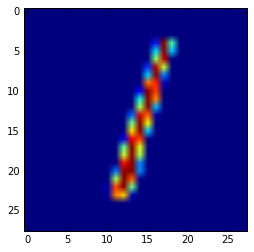

In [14]:
test_x, test_y = mnist.test.next_batch(1)

plt.imshow(test_x.reshape(28, 28))
plt.show()

In [15]:
test_x = np.reshape(test_x, [-1, n_steps, n_input])
predict_x = sess.run(pred, feed_dict={x: test_x})
print (np.argmax(predict_x, 1)[0])

1


In [11]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>